In [93]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
from collections import defaultdict

# Dictionary to hold dataframes grouped by strategy
dict_df = defaultdict(list)

# Read all energy history files
for file in glob.glob("../output/energy_history_*.csv"):
    # Extract strategies and user count from file name
    # Example filename: energy_history_AllOnStrategy_TimeGreedy_56.csv
    parts = file.split("_")
    power_strategy = parts[2]
    assignment_strategy = parts[3]
    user_count = int(parts[4].replace(".csv", ""))

    # Create a combined strategy key
    strategy_key = f"{power_strategy} + {assignment_strategy}"

    # Read the file into a DataFrame
    df = pd.read_csv(file)

    # Store the data grouped by combined strategies
    dict_df[strategy_key].append(
        {
            "user_count": user_count,
            "power_strategy": power_strategy,
            "assignment_strategy": assignment_strategy,
            "data": df,
        }
    )

In [94]:
def analyze_energy(
    dict_df, power_strategy=None, assignment_strategy=None, graph_type="energy_vs_users"
):
    """
    Analyze energy-specific metrics or generate plots.

    Parameters:
        dict_df (defaultdict): Dictionary containing strategy data.
        power_strategy (list or str): The power strategy or list of strategies to analyze (default: None for all).
        assignment_strategy (list or str): The assignment strategy or list of strategies to analyze (default: None for all).
        graph_type (str): Type of graph to generate ("energy_vs_users", "energy_per_user", or "box_plot").
    """
    # Ensure power_strategy and assignment_strategy are lists for uniform processing
    if isinstance(power_strategy, str):
        power_strategy = [power_strategy]
    if isinstance(assignment_strategy, str):
        assignment_strategy = [assignment_strategy]

    # Filter data by strategies
    filtered_data = {
        strategy_key: data
        for strategy_key, data in dict_df.items()
        if (not power_strategy or any(ps in strategy_key for ps in power_strategy))
        and (
            not assignment_strategy
            or any(as_ in strategy_key for as_ in assignment_strategy)
        )
    }

    if graph_type == "energy_vs_users":
        plt.figure(figsize=(10, 6))

        # Define different line styles and markers
        line_styles = [
            ("solid", "o"),
            ("dashed", "s"),
            ("dashdot", "^"),
            ("dotted", "D"),
            ("-", "v"),
            ("--", "p"),
        ]

        for idx, (strategy_key, data) in enumerate(filtered_data.items()):
            user_counts = []
            cumulative_energies = []

            for entry in data:
                cumulative_energy = entry["data"].sum().sum()
                user_counts.append(entry["user_count"])
                cumulative_energies.append(cumulative_energy)

            # Sort the data
            sorted_data = sorted(zip(user_counts, cumulative_energies))
            user_counts, energies = zip(*sorted_data)

            # Use different line style and marker for each line
            line_style, marker = line_styles[idx % len(line_styles)]
            plt.plot(
                user_counts,
                energies,
                linestyle=line_style,
                marker=marker,
                markersize=8,
                label=strategy_key,
            )

        plt.title("Energy vs Users")
        plt.xlabel("Number of Users")
        plt.ylabel("Total Energy (J)")
        plt.grid(True)
        plt.legend(title="Strategies", bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.tight_layout()  # Adjust layout to prevent legend cutoff
        plt.show()

    elif graph_type == "energy_per_user":
        plt.figure(figsize=(10, 6))
        for strategy_key, data in filtered_data.items():
            user_counts = []
            energy_per_user = []

            for entry in data:
                total_energy = entry["data"].sum().sum()
                user_counts.append(entry["user_count"])
                energy_per_user.append(total_energy / entry["user_count"])

            sorted_data = sorted(zip(user_counts, energy_per_user))
            user_counts, energies = zip(*sorted_data)

            plt.plot(user_counts, energies, marker="o", label=strategy_key)

        plt.title("Energy per User")
        plt.xlabel("Number of Users")
        plt.ylabel("Energy per User (J)")
        plt.grid(True)
        plt.legend(title="Strategies")
        plt.show()

    elif graph_type == "box_plot":
        power_strategies = defaultdict(list)
        for strategy_key, data in filtered_data.items():
            power_strat = strategy_key.split(" + ")[0]
            for entry in data:
                power_strategies[power_strat].append(entry["data"].sum().sum())

        plt.figure(figsize=(10, 6))
        plt.boxplot(power_strategies.values(), labels=power_strategies.keys())
        plt.title("Energy Distribution by Power Strategy")
        plt.ylabel("Total Energy (J)")
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.show()

    else:
        print(
            "Unsupported graph type. Choose 'energy_vs_users', 'energy_per_user', or 'box_plot'."
        )

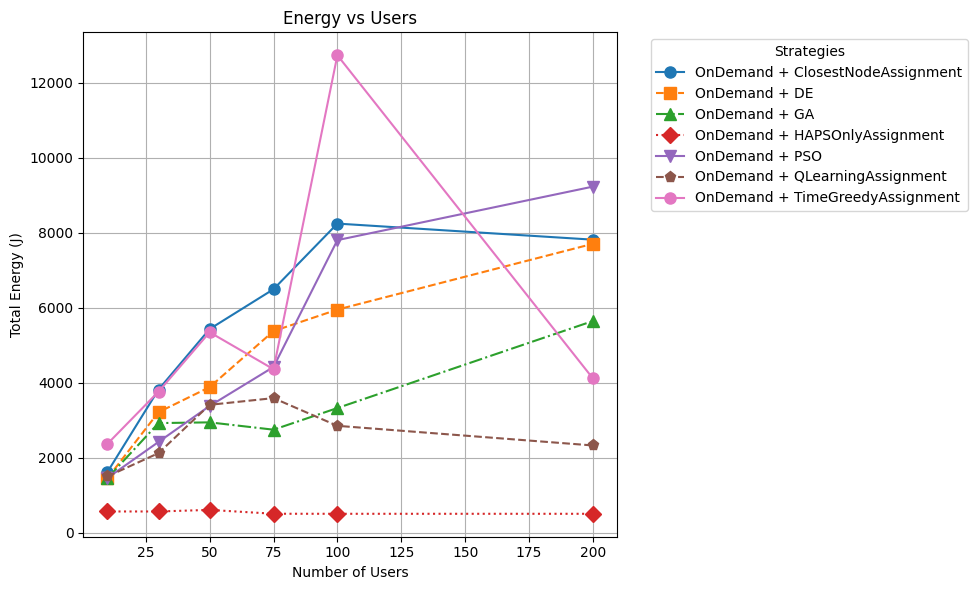

In [95]:
analyze_energy(
    dict_df,
    assignment_strategy=[
        "TimeGreedy",
        "ClosestNode",
        "HAPSOnly",
        "GA",
        "PSO",
        "DE",
        "QLearning",
    ],
    power_strategy=["OnDemand"],
    graph_type="energy_vs_users",
)

In [96]:
# After your plot_energy function and example plots, add this:


def print_energy_table(dict_df, user_count=100):
    """
    Print a formatted table of cumulative energy consumption for all strategy pairs.

    Parameters:
        dict_df (dict): Dictionary containing energy data
        user_count (int): Filter results for this user count
    """
    # Create a list to store results
    results = []

    # Collect data for each strategy pair
    for strategy_key, runs in dict_df.items():
        # Find the run with specified user count
        selected_run = next(
            (run for run in runs if run["user_count"] == user_count), None
        )

        if selected_run:
            # Calculate total energy
            df = selected_run["data"]
            # Exclude user-specific columns
            df = df.drop(columns=df.filter(regex="^User").columns)
            total_energy = df.sum().sum()

            # Split strategy key into components
            power_strat, assign_strat = strategy_key.split(" + ")

            # Add to results
            results.append(
                {
                    "Power Strategy": power_strat,
                    "Assignment Strategy": assign_strat,
                    "Total Energy (J)": total_energy,
                }
            )

    # Convert to DataFrame for nice display
    results_df = pd.DataFrame(results)

    # Sort by total energy
    results_df = results_df.sort_values("Total Energy (J)")

    # Format the energy values to 2 decimal places
    results_df["Total Energy (J)"] = results_df["Total Energy (J)"].map(
        "{:,.2f}".format
    )

    print(f"\nCumulative Energy Consumption for {user_count} Users:")
    print("=" * 80)
    print(results_df.to_string(index=False))
    print("=" * 80)

    return results_df  # Return the DataFrame in case you want to use it later


# Example usage:
energy_table = print_energy_table(dict_df, user_count=10)


Cumulative Energy Consumption for 10 Users:
Power Strategy   Assignment Strategy Total Energy (J)
      OnDemand    HAPSOnlyAssignment           562.00
      OnDemand                    GA         1,448.79
      OnDemand                    DE         1,448.85
      OnDemand                   PSO         1,454.39
      OnDemand   QLearningAssignment         1,496.47
      OnDemand ClosestNodeAssignment         1,614.11
      OnDemand  TimeGreedyAssignment         2,364.66
